In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import datetime as dt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats

plt.rcParams.update({'font.size':16})

# Functions

In [2]:
#Function to train the linear regression with Corona cases on co2 emissions
# df_cor needs one column named 'cases' with the Covid-19 cases in Germany
# df_co2 needs one column named 'co2' 

def TrainLRCoronaOnCO2(df_cor, df_co2, verbose=True):
    
    #convert datetime index to string index if needed
    #for corona case numbers dataframe
    try: 
        df_cor.index = df_cor.index.strftime('%Y-%m')
    except:
        pass
    #for co2 emissions dataframe
    try: 
        df_co2.index = df_co2.index.strftime('%Y-%m')
    except:
        pass
    
    #reduce dataframes to 2019 and 2020 and concat them
    df_cor = df_cor.loc['2018-12':'2020-06']
    df_co2 = df_co2.loc['2018-12':'2020-06']
    df = pd.concat([df_cor, df_co2], axis=1)

    #calcualte difference between 2019 co2 emissions and 2020 co2 emissions
    diff_co2_1920 = ((df.loc['2018-12':'2019-06', 'co2'].to_numpy() - df.loc['2019-12':'2020-06', 'co2'].to_numpy())/df.loc['2018-12':'2019-06', 'co2'].to_numpy())
    
    #add diff co2 to dataframe
    df = df.loc['2019-12':'2020-06']
    df['diff_co2_1920'] = diff_co2_1920

    #train linear regression
    lr_cor_co2 = LinearRegression() #fit_intercept=False
    lr_cor_co2.fit(df.cases.values.reshape(-1, 1), df.diff_co2_1920)
    
    #test on same data
    pred_diff_co2_1920 = lr_cor_co2.predict(df.cases.values.reshape(-1, 1))
    
    #add predictions to dataframe
    df['pred_diff_co2_1920'] = pred_diff_co2_1920
    
    
    #plot result
    if verbose:
        print('r2: ', round(r2_score(diff_co2_1920, pred_diff_co2_1920),2))
        print('RMSE: ', round(np.sqrt(mean_squared_error(diff_co2_1920, pred_diff_co2_1920)),2))
        df[['diff_co2_1920', 'pred_diff_co2_1920']].plot(figsize=(12,9))
        plt.grid()
        plt.xlabel('Difference in Mio tons CO2 to 2019')
        
        #scatter plot
        g = sns.JointGrid(x=diff_co2_1920,y=pred_diff_co2_1920, ratio=100)
        g.plot_joint(sns.regplot)
        g.annotate(stats.pearsonr)
        g.ax_marg_x.set_axis_off()
        g.ax_marg_y.set_axis_off()
        plt.xlabel('diff_co2_1920')
        plt.ylabel('pred_diff_co2_1920')
        
    return lr_cor_co2
    
#use the linear model from "TrainLRCoronaOnCO2" to estimate the impact of cases on co2 
def EstimateCO2withCorona(lr_cor_co2, df_co2, df_cases_new):
    
    cases = df_cases_new.cases.to_numpy()
    for i in range(len(cases)):
        if cases[i] > 90000:
            cases[i] = 90000
        elif cases[i] < 0:
            cases[i] = 0
        
        
    pred_diff = lr_cor_co2.predict(df_cases_new.cases.values.reshape(-1, 1))
    
    pred = df_co2.loc['2019-07':'2019-12', 'co2'].to_numpy() * (1-pred_diff) 
    
    df_ret = pd.DataFrame({'co2':pred}, index=df_cases_new.index)
    
    return df_ret
    

## Mobility

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


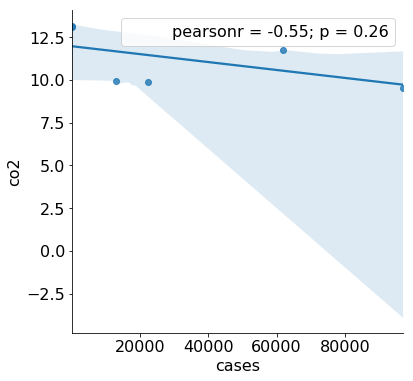

In [3]:
#corona
df_cor = pd.read_csv('../../data/corona/CORONA_GERMANY.csv')
df_cor = df_cor.rename(columns={'myDt': 'date'})
df_cor.index = df_cor.date
df_cor = df_cor.drop('date', axis=1)

#co2
df_co2 = pd.read_csv('../../models/MappingModels/Mobility_Features_LASSOResult_ÖkoCO2.csv', index_col='date')
df_co2 = df_co2[['FuelSale_tons_ottokraftstoff_insg', 'FuelSale_tons_dieselkraftstoff_insg', 'OekoInstitute', 'LASSO']]
#df_co2 = mob.rename(columns={'LASSO':'co2'})
df_co2 = df_co2.rename(columns={'LASSO':'co2'})

df = pd.concat([df_cor, df_co2], axis=1)
df = df[['cases', 'co2']]

df = df.loc['2019:12':'2020-06']
g = sns.JointGrid(x=df.cases,y=df.co2, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

## Function calls

r2:  0.36
RMSE:  0.12


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


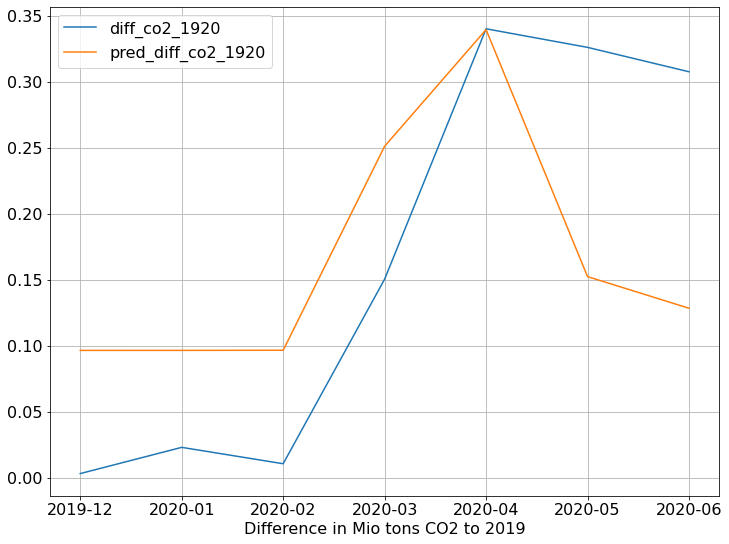

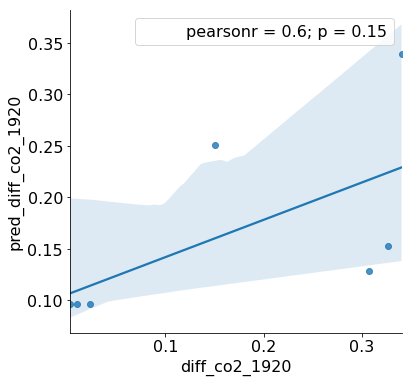

In [4]:
lr_cor_co2 = TrainLRCoronaOnCO2(df_cor, df_co2)

# Estimate CO2 based on Corona cases

In [5]:
#change the values of new cases here!
val = [90000, 90000, 90000, 90000, 90000, 90000]

date = ['2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']
df_cases_new = pd.DataFrame({'cases': val}, index=date)

df_pred = EstimateCO2withCorona(lr_cor_co2, df_co2, df_cases_new)
df_co2_plot = df_co2.append(df_pred).loc['2019-12':'2020-12', 'co2']




Text(0.5, 1.0, 'Covid-19 cases in Germany 2020')

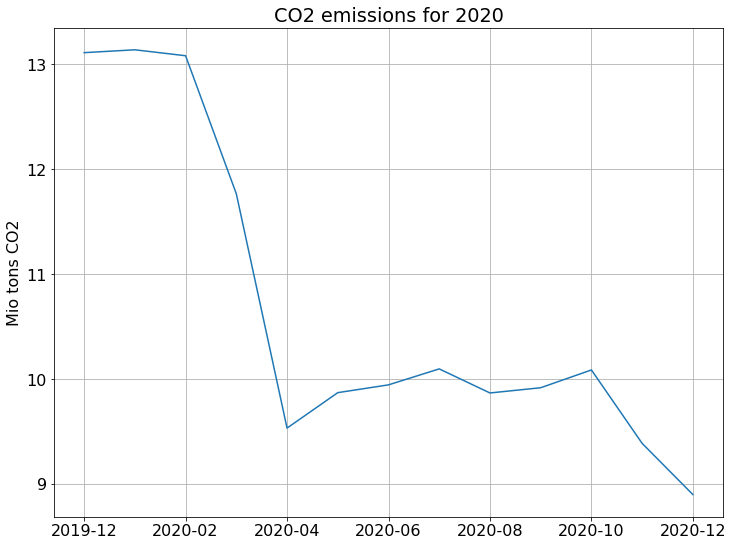

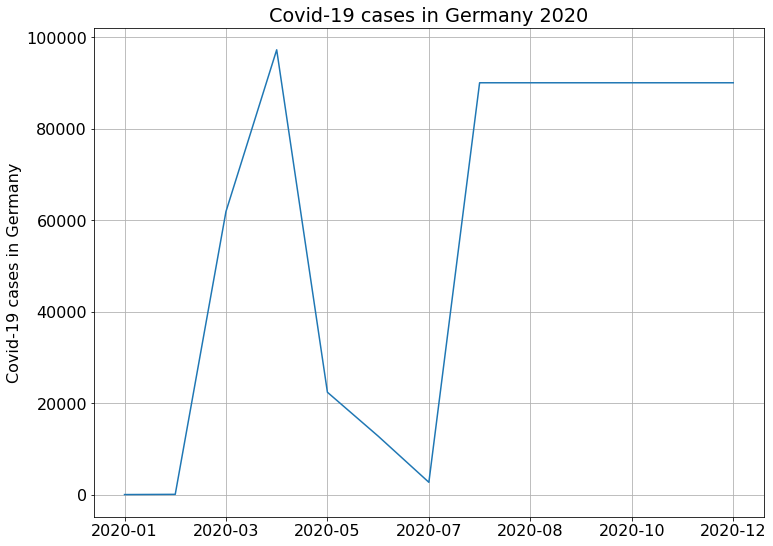

In [6]:
plt.figure()
df_co2_plot.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('CO2 emissions for 2020')

plt.figure()
df_cor_plot = df_cor.append(df_cases_new).loc['2020-01':'2020-12']
df_cor_plot['cases'].plot(figsize=(12,9))
plt.grid()
plt.ylabel('Covid-19 cases in Germany')
plt.title('Covid-19 cases in Germany 2020')

# Energy

In [7]:
# Import whole database
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)
    
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1)

#convert index in datetime format            
X_eh_raw['date'] = X_eh_raw.index
X_eh_raw.date = pd.to_datetime(X_eh_raw.date).dt.to_period('m')
X_eh_raw.index = X_eh_raw.date
X_eh_raw = X_eh_raw.drop('date', axis=1)

X_eh_raw = X_eh_raw.loc['2018-12':'2020-06']
X_eh_raw = X_eh_raw.dropna(axis=1)

#gesamt CO2 emissionen von Energie
CO2 = []
for col in X_eh_raw:
    if 'CO2' in col:
        if len(CO2) == 0:
            CO2 = X_eh_raw[col].values
        else:
            CO2 = CO2 + X_eh_raw[col].values




X_eh_raw = X_eh_raw.drop('Deutschland', axis=1)
for col in X_eh_raw:
    X_eh_raw = X_eh_raw.drop(col, axis=1)

df_co2 = X_eh_raw.copy()
df_co2['co2'] = CO2

df_co2

,co2
date,
2018-12,1.707572e+07
2019-01,1.973911e+07
2019-02,1.782568e+07
2019-03,1.607082e+07
2019-04,1.448578e+07
2019-05,1.519590e+07
2019-06,1.308170e+07
2019-07,1.419184e+07
2019-08,1.385342e+07


r2:  0.24
RMSE:  0.1


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1734: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


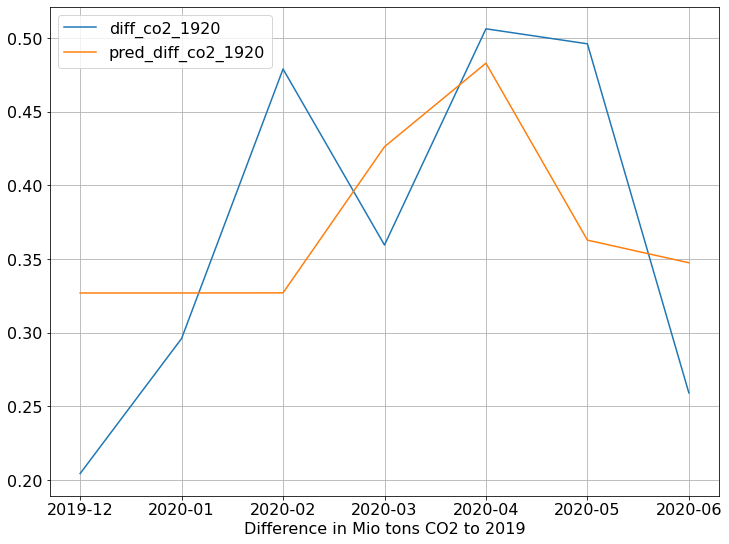

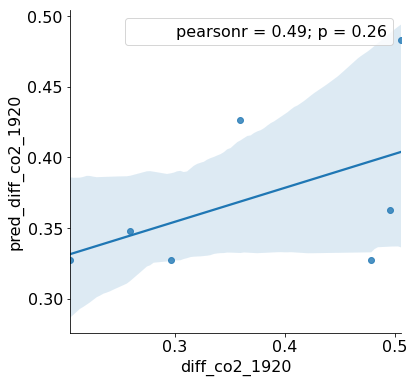

In [8]:
lr_cor_co2 = TrainLRCoronaOnCO2(df_cor, df_co2)

Text(0.5, 1.0, 'Covid-19 cases in Germany 2020')

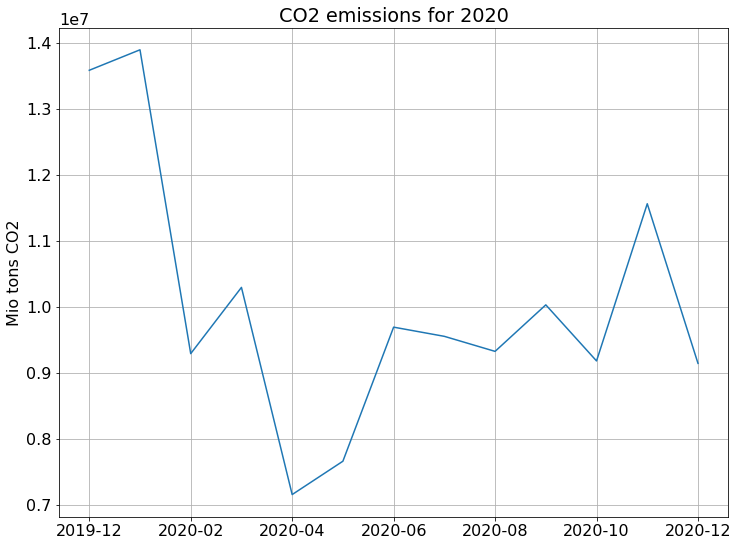

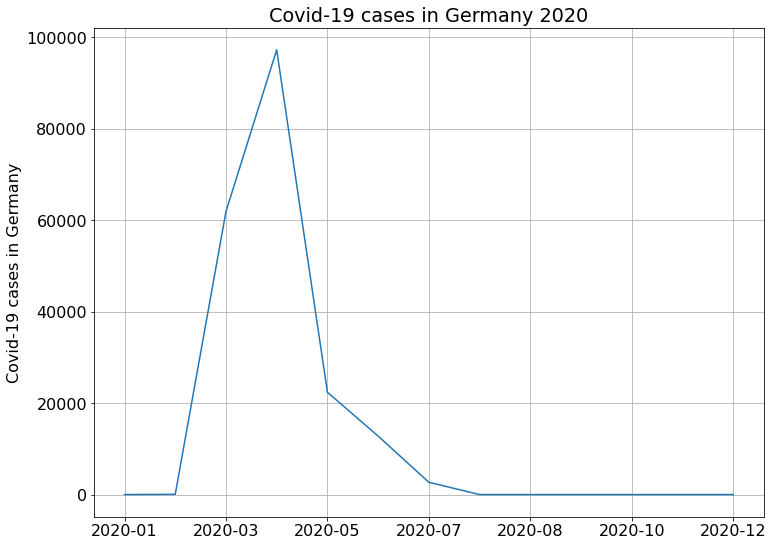

In [9]:
#change the values of new cases here!
val = [0, 0, 0, 0, 0, 0]

date = ['2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']
df_cases_new = pd.DataFrame({'cases': val}, index=date)

df_pred = EstimateCO2withCorona(lr_cor_co2, df_co2, df_cases_new)
df_co2_plot = df_co2.append(df_pred).loc['2019-12':'2020-12', 'co2']

plt.figure()
df_co2_plot.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('CO2 emissions for 2020')

plt.figure()
df_cor_plot = df_cor.append(df_cases_new).loc['2020-01':'2020-12']
df_cor_plot['cases'].plot(figsize=(12,9))
plt.grid()
plt.ylabel('Covid-19 cases in Germany')
plt.title('Covid-19 cases in Germany 2020')

Text(0.5, 1.0, 'Covid-19 cases in Germany 2020')

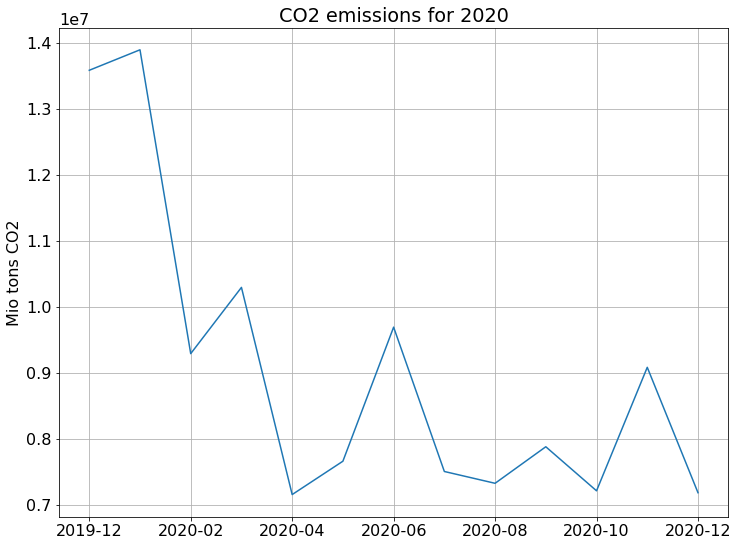

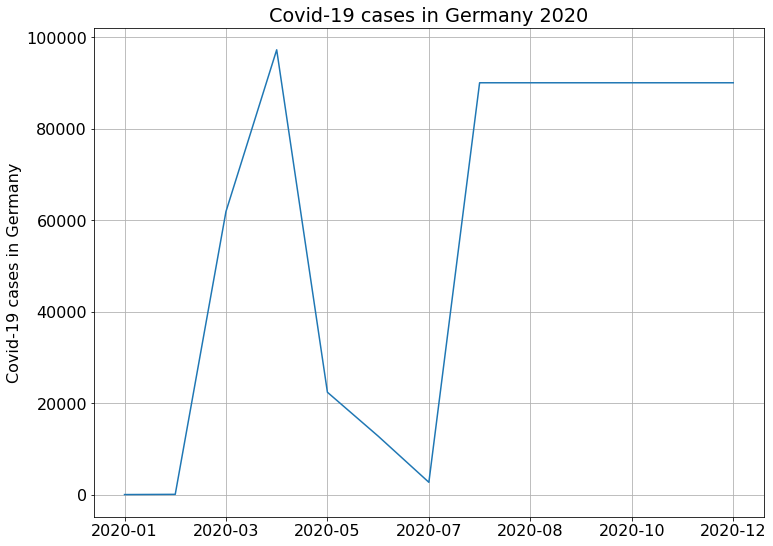

In [10]:
#change the values of new cases here!
val = [90000, 90000, 90000, 90000, 90000, 90000]

date = ['2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']
df_cases_new = pd.DataFrame({'cases': val}, index=date)

df_pred = EstimateCO2withCorona(lr_cor_co2, df_co2, df_cases_new)
df_co2_plot = df_co2.append(df_pred).loc['2019-12':'2020-12', 'co2']

plt.figure()
df_co2_plot.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('CO2 emissions for 2020')

plt.figure()
df_cor_plot = df_cor.append(df_cases_new).loc['2020-01':'2020-12']
df_cor_plot['cases'].plot(figsize=(12,9))
plt.grid()
plt.ylabel('Covid-19 cases in Germany')
plt.title('Covid-19 cases in Germany 2020')